<h1>Chapter 4 | Data Exercise #3 | <code>wms-management-survey</code> | Comparison and correlation</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 3</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>2. Using the <code>wms-management-survey</code> dataset:</p>
<p>Assignments:</p>
<ul>
    <li>Pick a country of your choice.</li>
    <li>Create a management score from a meaningful subset of the 18 items (e.g. managing talent).</li>
    <li>Carry out an analysis to uncover the patterns of association with employment.</li>
    <li>Summarize what you find and comment on which visualization you find the most useful.</li>
</ul>
<h2><b>1.</b> Load the data</h2>

In [27]:
import os
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
from mizani.formatters import percent_format

warnings.filterwarnings("ignore")
%matplotlib inline

In [28]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [29]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_data_exercises")[0]

# Get location folders
data_in = f"{dirname}da_data_repo/wms-management-survey/clean/"
data_out = f"{dirname}da_data_exercises/ch04-comparison_correlation/03-wms_management_ex2/data/clean/"
output = f"{dirname}da_data_exercises/ch04-comparison_correlation/03-wms_management_ex2/"
func = f"{dirname}da_case_studies/ch00-tech_prep/"
sys.path.append(func)

In [30]:
from py_helper_functions import *

In [31]:
df = pd.read_csv(f"{data_in}wms_da_textbook.csv", usecols=[*range(0, 32)]) # exclude logical variables that won't be used in this exercise

In [32]:
df["country"].unique()

array(['United States', 'India', 'New Zealand', 'Australia', 'Argentina',
       'Brazil', 'Canada', 'Chile', 'China', 'Germany', 'Spain', 'France',
       'Northern Ireland', 'Great Britain', 'Greece',
       'Republic of Ireland', 'Italy', 'Japan', 'Mexico', 'Poland',
       'Portugal', 'Sweden', 'Singapore', 'Turkey'], dtype=object)

In [33]:
df_2014 = df.loc[df["wave"] == 2014]
df_2014["country"].value_counts()

country
Italy            318
Greece           313
Great Britain    296
United States    217
France           141
Portugal          99
Germany           77
Name: count, dtype: int64

<h3>1.1 Sample selection</h3>
<p>Let's pick a country with different proportions than Mexico yet let's apply the same exclusions made by the author, that is, filtering out firms with fewer than 100 employees and more than 5000 employees. We will pick a different year and a country with a possibly different industry structure - let's pick <b>Italy</b>.</p>

In [34]:
df = df.loc[
    lambda x: (x["country"] == "Italy") &
              (x["wave"] == 2014) &
              (x["emp_firm"] >= 100) &
              (x["emp_firm"] <= 5000)
]

In [35]:
df["emp_firm"].describe()

count     281.000000
mean      537.131673
std       818.237523
min       100.000000
25%       150.000000
50%       240.000000
75%       500.000000
max      4800.000000
Name: emp_firm, dtype: float64

In [36]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent1,talent2,talent3,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn
10051,7214,2014,it,Italy,25.0,3.111111,2.5,3.6,3.2,2.833333,...,3.0,2.0,4.0,3.0,2.0,3.0,320.0,52.0,Private Equity/Venture Capital,0.0
10055,7217,2014,it,Italy,30.0,2.777778,3.0,3.0,2.6,2.666667,...,3.0,3.0,3.0,2.0,3.0,2.0,140.0,5.0,Dispersed Shareholders,1.0
10057,7219,2014,it,Italy,34.0,3.222222,4.0,4.4,2.6,2.500000,...,2.0,1.0,2.0,3.0,3.0,4.0,290.0,60.0,Private Individuals,1.0
10059,7220,2014,it,Italy,36.0,4.388889,4.5,5.0,4.0,4.166667,...,4.0,3.0,5.0,4.0,5.0,4.0,3000.0,44.0,"Family owned, external CEO",1.0
10062,7221,2014,it,Italy,24.0,2.000000,2.0,2.0,1.6,2.333333,...,1.0,2.0,3.0,3.0,2.0,3.0,120.0,38.0,"Founder owned, founder CEO",0.0


<h2>2. Create a management score from a meaningful subset of the 18 items (e.g. managing talent).</h2>
<p>Let's explore the 18 items available on our dataset.</p>

In [37]:
df.columns

Index(['firmid', 'wave', 'cty', 'country', 'sic', 'management', 'operations',
       'monitor', 'target', 'people', 'lean1', 'lean2', 'perf1', 'perf2',
       'perf3', 'perf4', 'perf5', 'perf6', 'perf7', 'perf8', 'perf9', 'perf10',
       'talent1', 'talent2', 'talent3', 'talent4', 'talent5', 'talent6',
       'emp_firm', 'firmage', 'ownership', 'mne_yn'],
      dtype='object')

In [38]:
df.select_dtypes(include="number").head()

,firmid,wave,sic,management,operations,monitor,target,people,lean1,lean2,...,perf10,talent1,talent2,talent3,talent4,talent5,talent6,emp_firm,firmage,mne_yn
10051,7214,2014,25.0,3.111111,2.5,3.6,3.2,2.833333,2.0,3.0,...,2.0,3.0,2.0,4.0,3.0,2.0,3.0,320.0,52.0,0.0
10055,7217,2014,30.0,2.777778,3.0,3.0,2.6,2.666667,3.0,3.0,...,3.0,3.0,3.0,3.0,2.0,3.0,2.0,140.0,5.0,1.0
10057,7219,2014,34.0,3.222222,4.0,4.4,2.6,2.500000,5.0,3.0,...,3.0,2.0,1.0,2.0,3.0,3.0,4.0,290.0,60.0,1.0
10059,7220,2014,36.0,4.388889,4.5,5.0,4.0,4.166667,5.0,4.0,...,4.0,4.0,3.0,5.0,4.0,5.0,4.0,3000.0,44.0,1.0
10062,7221,2014,24.0,2.000000,2.0,2.0,1.6,2.333333,2.0,2.0,...,2.0,1.0,2.0,3.0,3.0,2.0,3.0,120.0,38.0,0.0


<p>It would be interesting to observe the correlation between firm size and performance indicators. Are larger firms more performatic than smaller ones? Let's find out.</p>
<p>Let's create a <code>peformance</code> score by taking the average score of all 10 performance indicators.</p>

In [39]:
df["performance"] = df.filter(like="perf").mean(axis=1)

In [40]:
df.filter(like="perf").head()

,perf1,perf2,perf3,perf4,perf5,perf6,perf7,perf8,perf9,perf10,performance
10051,4.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,2.0,3.4
10055,2.0,4.0,3.0,4.0,2.0,3.0,3.0,3.0,1.0,3.0,2.8
10057,4.0,5.0,4.0,5.0,4.0,2.0,2.0,3.0,3.0,3.0,3.5
10059,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,4.5
10062,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.8


<p>Great, we created our performance score out of 10 columns! Let's move on.</p>
<h2>3. Carry out an analysis to uncover the patterns of association with employment.</h2>
<h3>3.1 Visualizing the distribution of performance score</h3>
<p>Let's first explore the distribution of the performance score.</p>

In [41]:
df["performance"].describe()

count    281.000000
mean       3.134836
std        0.630996
min        1.400000
25%        2.700000
50%        3.100000
75%        3.500000
max        4.600000
Name: performance, dtype: float64

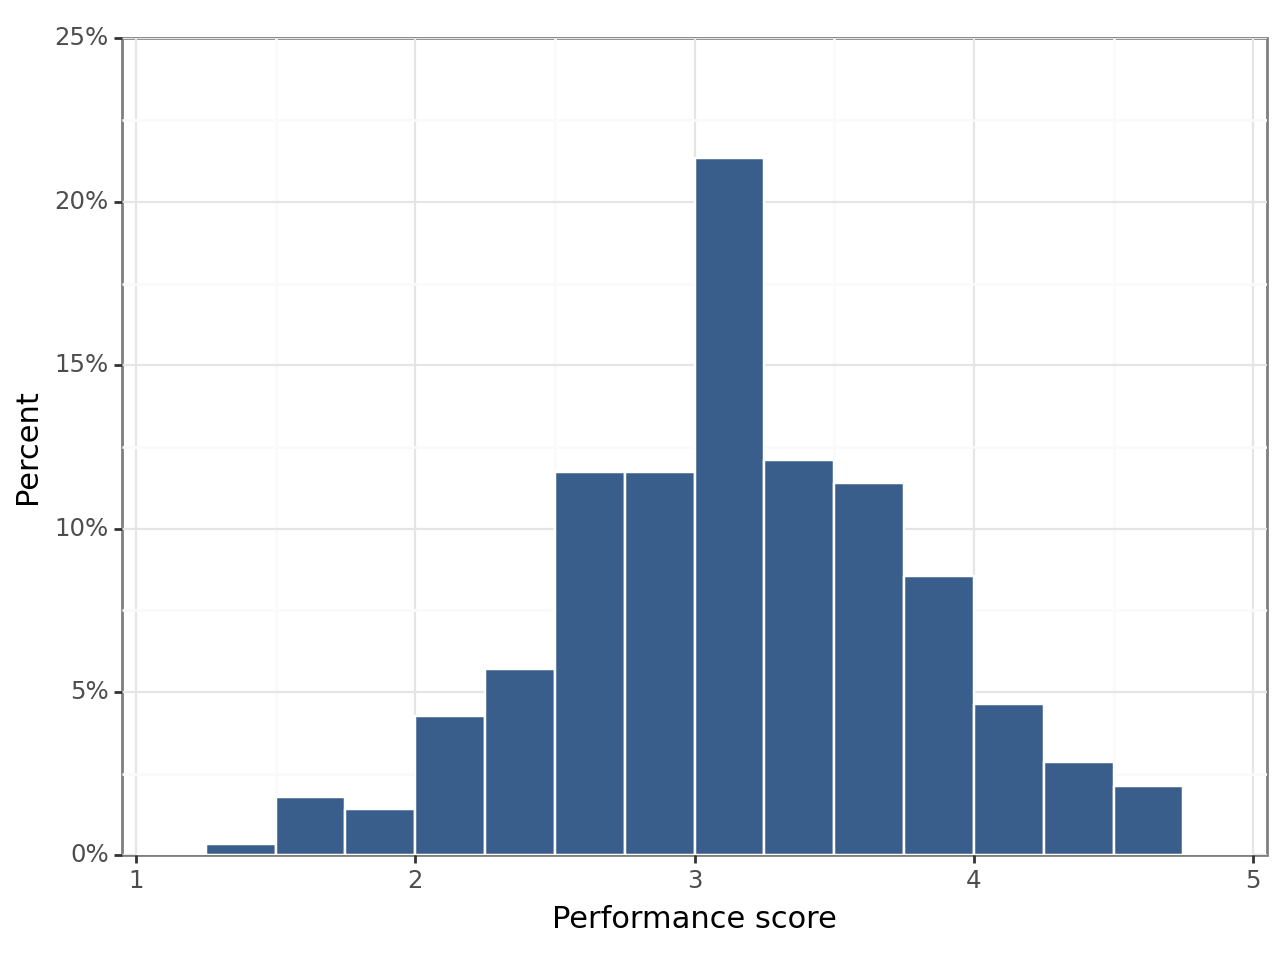

<Figure Size: (640 x 480)>

In [42]:
ggplot(df, aes(x="performance")) + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    fill=color[0],
    color="white",
    binwidth=0.25,
    boundary=0,
    closed="left",
) + labs(x="Performance score", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(1, 5)
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.25),
    breaks=seq(0, 0.26, by=0.05),
    labels=percent_format()
) + theme_bw()

Some observations about the histogram:
<ul>
<li>The mean is <b>3.13</b>, while the median is <b>3.1</b>. The dataset resembles a normal distribution, with a small degree of skewness to the left.</li>
<li>The standard deviation is <b>0.63</b>.</li>
<li>The mode is in the bin between <b>3</b> and <b>3.25</b>.
</ul>
<h3>3.2 Visualizing the distribution of employment</h3>
<p>We can start by looking at the summary statistics of Italian firms by their respective size, which is measured by the number of employees employed by each firm.</li>

In [43]:
df.loc[:, ["emp_firm"]].describe()

,emp_firm
count,281.000000
mean,537.131673
std,818.237523
min,100.000000
25%,150.000000
50%,240.000000
75%,500.000000
max,4800.000000


<p>Observations:</p>
<ul>
<li>The mean is <b>537</b> and the median, <b>240</b>.</li>
<li>The mean is far higher than the median and therefore we can expect a significant degree of <b>skewness</b> to the right.</li>
<li>The standard deviation is <b>818</b>.
</ul>

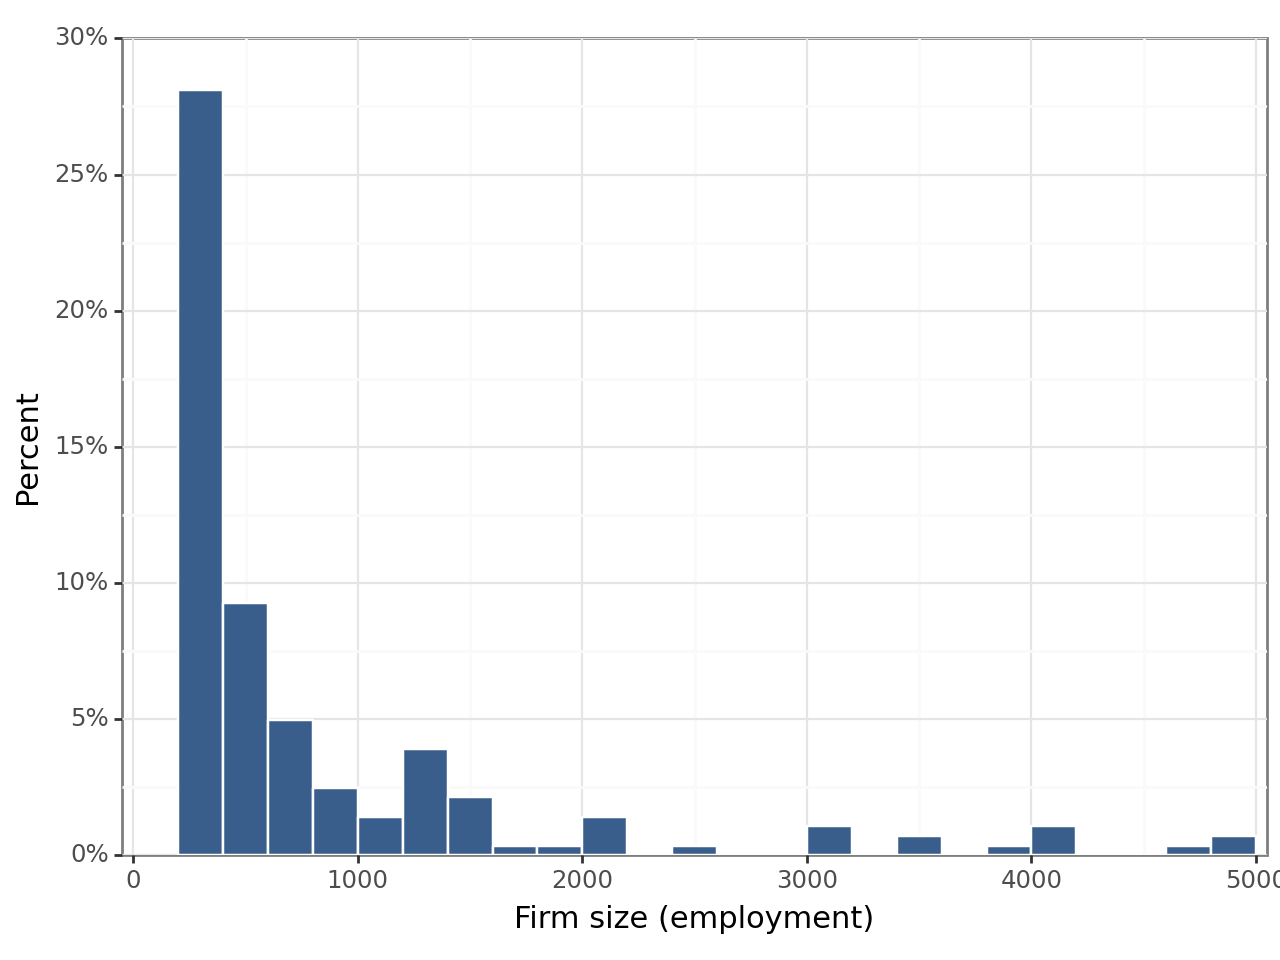

<Figure Size: (640 x 480)>

In [44]:
ggplot(df, aes(x="emp_firm", y="stat(count)/sum(stat(count))")) + geom_histogram(
    fill=color[0], color="white", binwidth=200, boundary=0, closed="left"
) + labs(x="Firm size (employment)", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5000), breaks=seq(0, 5001, by=1000)
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.3),
    breaks=seq(0, 0.5, by=0.05),
    labels=percent_format(),
) + theme_bw()

The histogram shows a high concentration of smaller firms in Italy. More specifically, more than 25% of all observations registered firms with less than 200 employees. Interestingly enough, there were no observations in the 200-400 bin.

To make this distribution more symmetric, we can plot a histogram formatted by the lognormal distribution.

In [45]:
df["lnemp_firm"] = np.log(df["emp_firm"])
df["lnemp_firm"].describe()

count    281.000000
mean       5.717706
std        0.930923
min        4.605170
25%        5.010635
50%        5.480639
75%        6.214608
max        8.476371
Name: lnemp_firm, dtype: float64

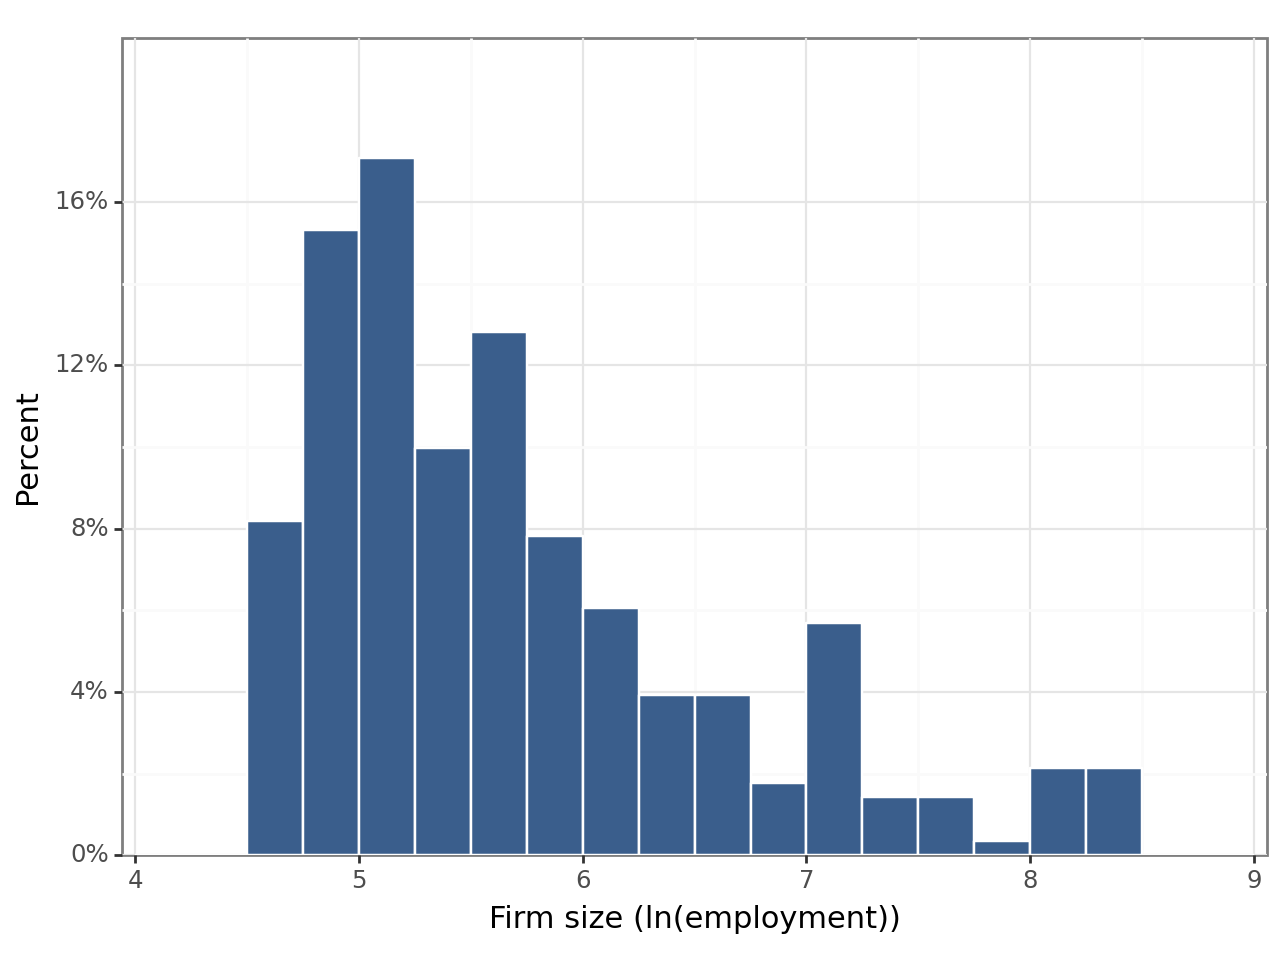

<Figure Size: (640 x 480)>

In [46]:
ggplot(df, aes(x="lnemp_firm"))  + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    fill=color[0], 
    color="white", 
    binwidth=0.25, 
    boundary=0, 
    closed="left"
) + labs(x="Firm size (ln(employment))", y="Percent") + scale_x_continuous(
    expand=(0.01, 0.01), limits=(4, 9) 
) + scale_y_continuous(
    expand=(0.00, 0.00),
    limits=(0, 0.2),
    breaks=seq(0, 0.2, by=0.04),
    labels=percent_format(),
) + theme_bw()

<p>We notice that the distribution is not as skewed as before, yet it still presents a longer tail to the right. The distribution, nonetheless, is much more symmetrical. In conclusion, the distribution of employment is skewed; while closer to lognormal than normal, the latter is still not the best approach.</p>
<h3>3.3 Conditional probabilities | Binning firm size</h3>
<p>As a reminder, <b>conditional probability</b> of an event means the probability of an event if another event (the conditioning event) happens. Because both the performance score and employment are quantitative variables with many values, they are not adequate for an investigation conditional probabilities.</p>
<p>To overcome this issue, we will create a <b>qualitative</b> variable by creating three bins of employment: <b>small, medium, and large</b>. Let's follow the book's example and bind the bins by three intervals: 100-199, 200-999, and 1000+.


In [47]:
df["emp3bins"] = np.where(df["emp_firm"] < 200, 1, np.nan)
df["emp3bins"] = np.where((df["emp_firm"] >= 200) & (df["emp_firm"] < 1000), 2, df["emp3bins"])
df["emp3bins"] = np.where(df["emp_firm"] >= 1000, 3, df["emp3bins"])

In [48]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn,performance,lnemp_firm,emp3bins
10051,7214,2014,it,Italy,25.0,3.111111,2.5,3.6,3.2,2.833333,...,3.0,2.0,3.0,320.0,52.0,Private Equity/Venture Capital,0.0,3.4,5.768321,2.0
10055,7217,2014,it,Italy,30.0,2.777778,3.0,3.0,2.6,2.666667,...,2.0,3.0,2.0,140.0,5.0,Dispersed Shareholders,1.0,2.8,4.941642,1.0
10057,7219,2014,it,Italy,34.0,3.222222,4.0,4.4,2.6,2.500000,...,3.0,3.0,4.0,290.0,60.0,Private Individuals,1.0,3.5,5.669881,2.0
10059,7220,2014,it,Italy,36.0,4.388889,4.5,5.0,4.0,4.166667,...,4.0,5.0,4.0,3000.0,44.0,"Family owned, external CEO",1.0,4.5,8.006368,3.0
10062,7221,2014,it,Italy,24.0,2.000000,2.0,2.0,1.6,2.333333,...,3.0,2.0,3.0,120.0,38.0,"Founder owned, founder CEO",0.0,1.8,4.787492,1.0


In [49]:
df["emp3bins"].describe()

count    281.000000
mean       1.733096
std        0.694319
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: emp3bins, dtype: float64

<p>We can make a few assumptions about the size of Italian firms by now.</p>
<ul>
<li>Italian firms tend to be medium-sized. The mean size is <b>1.73</b>, while the median is <b>2</b>.</li>
<li>The standard deviation is <b>0.69</b>, hence we can expect some variability in our dataset.</ul>
<li>As we already know, large firms in Italy tend to be a smaller fraction. We could see that in the distribution of the dataset, but considering the 25th percentile, we notice that a relevant portion of the companies are small to medium-sized.</li>
<h3>3.5 Plotting stacked charts - Describing patterns of association</h3>
<p>We will use stacked charts to visualize conditional probabilities. Because we have 15 conditional probabilities for each performance score (that is, the probability of each of the 5 values of y by each of the three values of x), a stacked bar chart will be of great assistance. Let's create the DataFrames for our job.</p>
<p>Let's choose two talent scores, `perf10` and `perf3`. The former measures "Clarity of Goals and Measurement", while the latter measures "Performance Review".

<h4>3.5.1 Stacked bar chart | (a) Clarity of Goals and Measurement</h4>

In [58]:
df1 = pd.DataFrame(
    df.loc[:, ["emp3bins", "perf10"]].groupby(["emp3bins", "perf10"]).agg("size")
).reset_index()

df1.columns = ["emp3bins", "perf10", "Count"]

group_counts = df1.groupby("emp3bins").agg("sum")["Count"]

df1.loc[df1["emp3bins"] == 1, "Percent"] = round(df1.loc[df1["emp3bins"] == 1, "Count"]/group_counts[1],5)
df1.loc[df1["emp3bins"] == 2, "Percent"] = round(df1.loc[df1["emp3bins"] == 2, "Count"]/group_counts[2],5)
df1.loc[df1["emp3bins"] == 3, "Percent"] = round(df1.loc[df1["emp3bins"] == 3, "Count"]/group_counts[3],5)

df1 = df1.assign(
    perf10=pd.Categorical(
        df1["perf10"], categories=sorted(set(df["perf10"]), reverse=True)
    )
)

In [59]:
df1

,emp3bins,perf10,Count,Percent
0,1.0,1.0,12,0.10435
1,1.0,2.0,55,0.47826
2,1.0,3.0,37,0.32174
3,1.0,4.0,10,0.08696
4,1.0,5.0,1,0.00870
5,2.0,1.0,11,0.08730
6,2.0,2.0,57,0.45238
7,2.0,3.0,43,0.34127
8,2.0,4.0,14,0.11111
9,2.0,5.0,1,0.00794


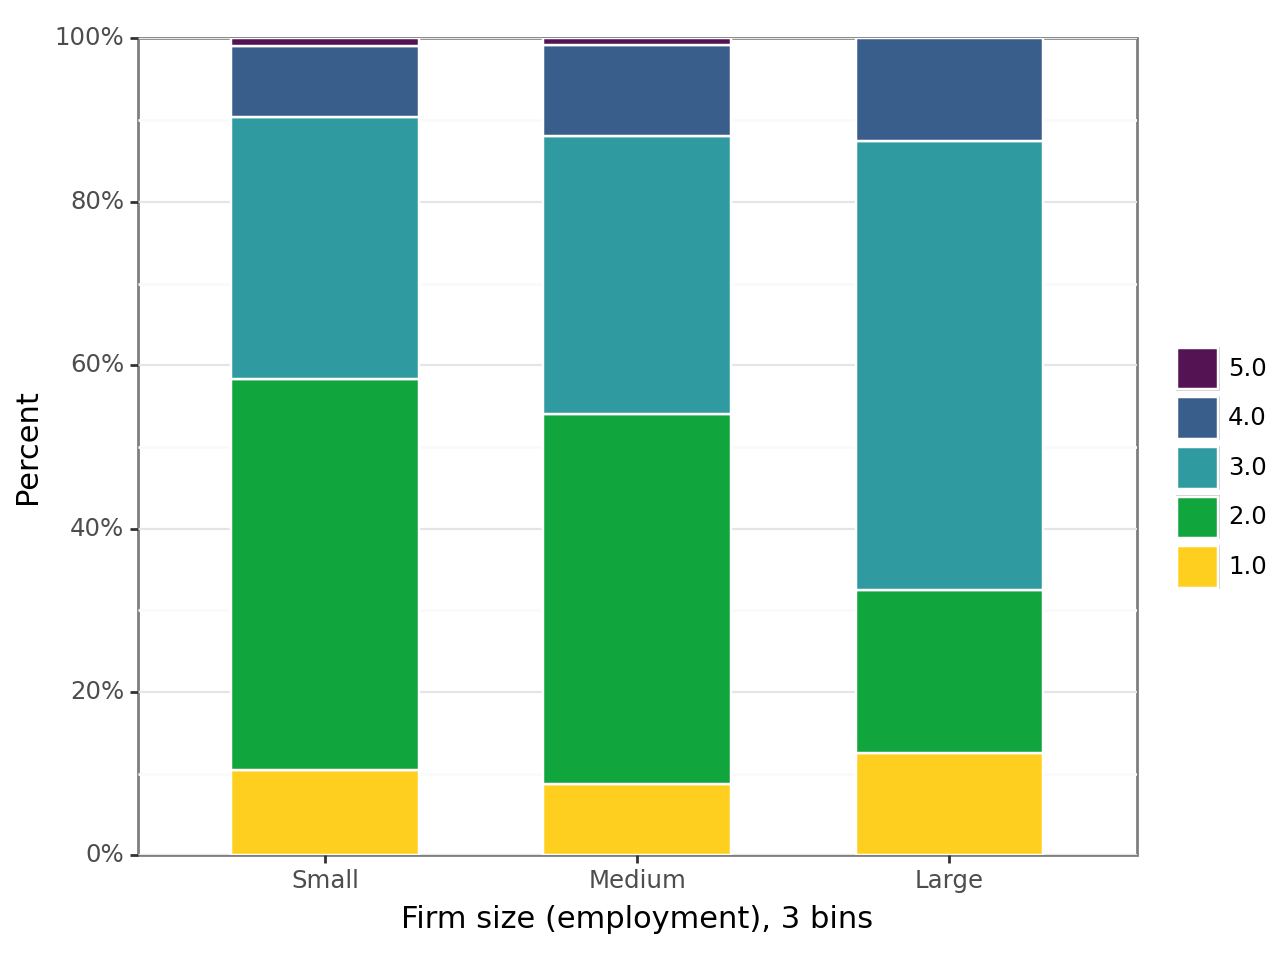

<Figure Size: (640 x 480)>

In [60]:
ggplot(df1, aes(x="emp3bins", y="Percent", fill="perf10")) + geom_bar(
    stat="identity", position="fill", width=0.6, color="white", size=0.5, alpha=0.8
) + scale_y_continuous( 
    expand=(0, 0), limits=(0, 1), breaks=seq(0, 1.1, by=0.2), labels=percent_format()
) + labs(
    x="Firm size (employment), 3 bins", y="Percent"
) + theme_bw() + theme(
    legend_position="right"
) + scale_fill_manual(
    values=(color[2], color[0], color[4], color[1], color[3]), name=" "
) + scale_x_discrete(limits=[1, 2, 3],
                     labels=["Small", "Medium", "Large"])

<h4>3.5.2 Stacked bar chart | (b) Performance Review</h4>

In [63]:
df2 = pd.DataFrame(
    df.loc[:, ["emp3bins", "perf3"]].groupby(["emp3bins", "perf3"]).agg("size")
).reset_index()

df2.columns = ["emp3bins", "perf3", "Count"]

group_counts = df2.groupby("emp3bins").agg("sum")["Count"]

df2.loc[df2["emp3bins"] == 1, "Percent"] = round(df2.loc[df2["emp3bins"] == 1, "Count"]/group_counts[1],5)
df2.loc[df2["emp3bins"] == 2, "Percent"] = round(df2.loc[df2["emp3bins"] == 2, "Count"]/group_counts[2],5)
df2.loc[df2["emp3bins"] == 3, "Percent"] = round(df2.loc[df2["emp3bins"] == 3, "Count"]/group_counts[3],5)

df2 = df2.assign(
    perf3=pd.Categorical(
        df2["perf3"], categories=sorted(set(df["perf3"]), reverse=True)
    )
)

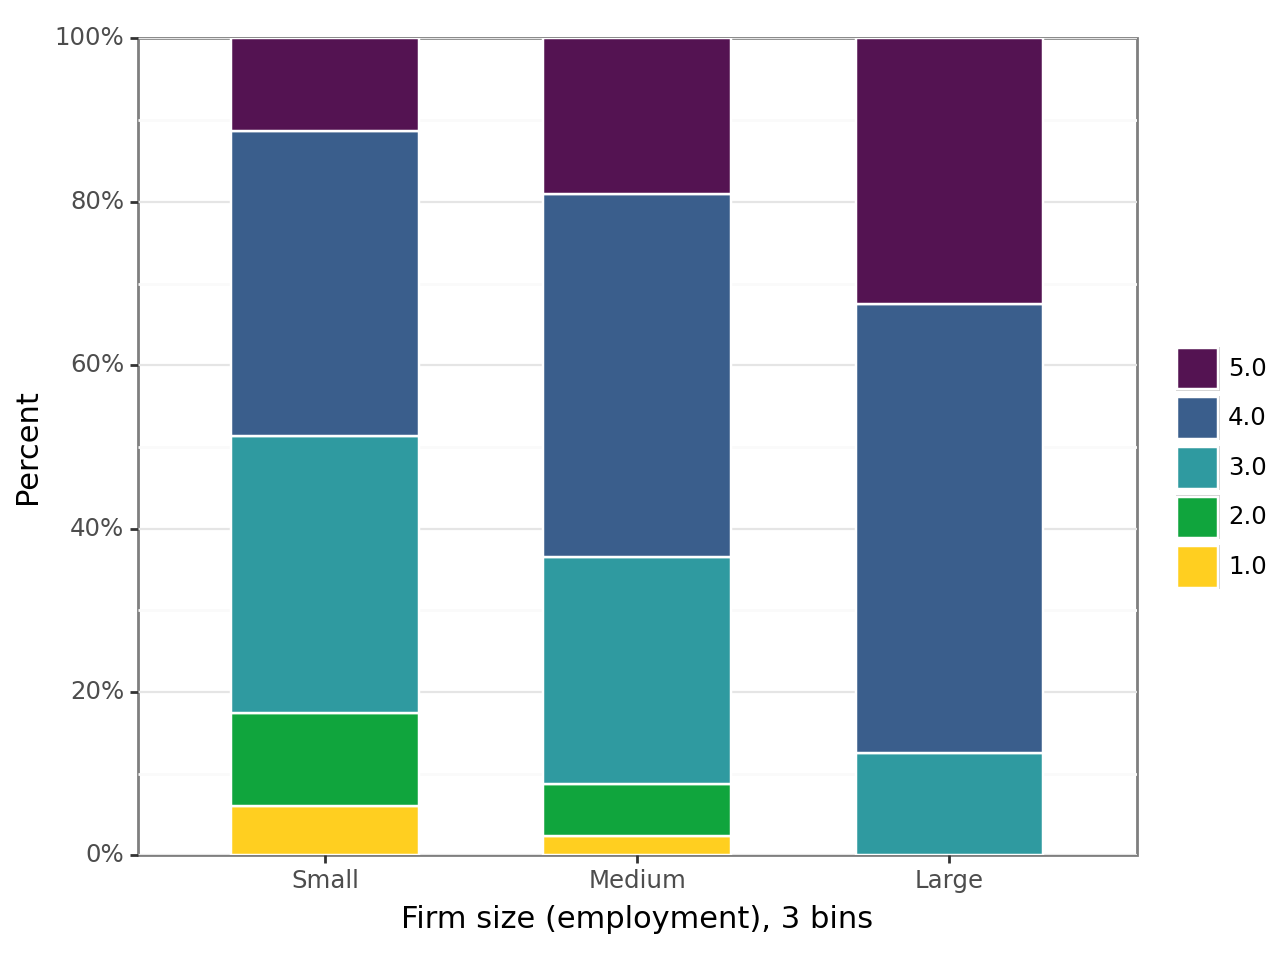

<Figure Size: (640 x 480)>

In [65]:
ggplot(df2, aes(x="emp3bins", y="Percent", fill="perf3")) + geom_bar(
    stat="identity", position="fill", width=0.6, color="white", size=0.5, alpha=0.8
) + scale_y_continuous( 
    expand=(0, 0), limits=(0, 1), breaks=seq(0, 1.1, by=0.2), labels=percent_format()
) + labs(
    x="Firm size (employment), 3 bins", y="Percent"
) + theme_bw() + theme(
    legend_position="right"
) + scale_fill_manual(
    values=(color[2], color[0], color[4], color[1], color[3]), name=" "
) + scale_x_discrete(limits=[1, 2, 3],
                     labels=["Small", "Medium", "Large"])

What can we observe from this chart? Well, overall, there is a positive correlation between lean management and firm size. As firm size gets bigger, we tend to see an increase in higher ratings and a decrease in lower values. Brazil has returned lean management results similar to Mexico. The correlation is similar in both cases, with a few difference. For instance, small firms in Brazil received lower ratings than in Mexico, with more than 60% of values equal or lower than 2 - in Mexico, this range registered a percentage of around 58%. Medium-sized firms, likewise, showed a large proportion of a score of 3 points, while Mexican firms with such firm size presented a higher proportion of 4 to 5 points. Brazilian large firms, however, were graded in a different way when compared to its Mexican counterparts. The proportion of firms rated with 1 to 2 points was around 21%, while in Mexico this range was around 32%. There was also a significant difference in 3 and 5 points ratings: Brazilian firms registered 37% of firms rated with 3 points, compared to 30% in Mexico, and 13% with 5 points, compared to 8% in Mexico. Considering that both countries registered similar proportions for 4 points, hence, we can affirm that Brazilian large-sized firms scored higher points than Mexican firms with similar sizes.

Let's plot the second stacked chart.
<h4>4.1.2 Stacked bar chart | Figure 4.3 (b) Performance tracking</h4>


In [29]:
df2 = pd.DataFrame(
    df.loc[:, ["emp3bins", "perf2"]].groupby(["emp3bins", "perf2"]).agg("size")
).reset_index()

df2.columns = ["emp3bins", "perf2", "Count"]

group_counts = df2.groupby("emp3bins").agg("sum")["Count"]

df2.loc[df2["emp3bins"] == 1, "Percent"] = round(df2.loc[df2["emp3bins"] == 1, "Count"]/group_counts[1],5)
df2.loc[df2["emp3bins"] == 2, "Percent"] = round(df2.loc[df2["emp3bins"] == 2, "Count"]/group_counts[2],5)
df2.loc[df2["emp3bins"] == 3, "Percent"] = round(df2.loc[df2["emp3bins"] == 3, "Count"]/group_counts[3],5)

df2 = df2.assign(
    perf2=pd.Categorical(
        df2["perf2"], categories=sorted(set(df["perf2"]), reverse=True)
    )
)

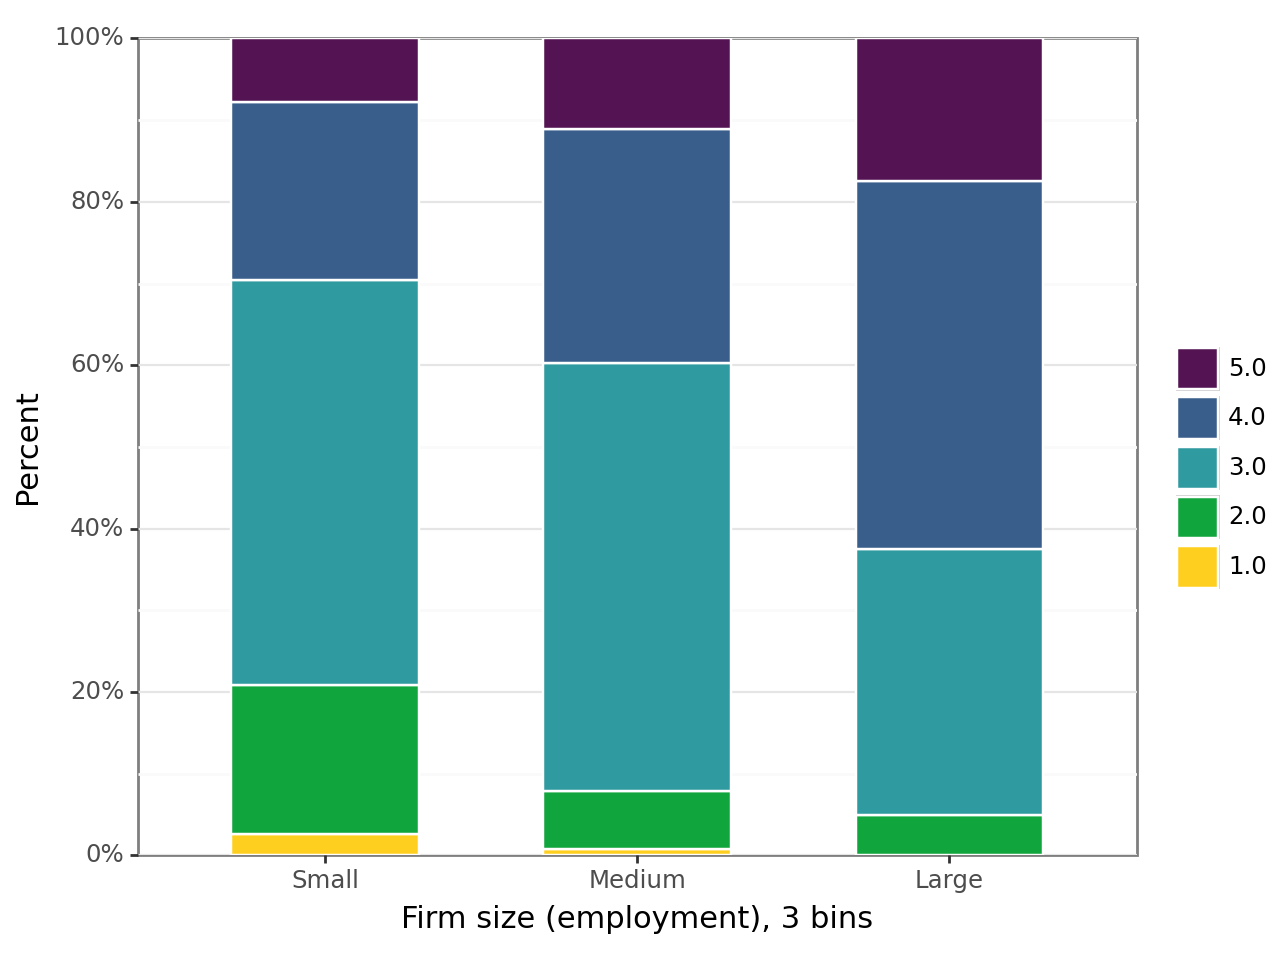

<Figure Size: (640 x 480)>

In [30]:
ggplot(df2, aes(x="emp3bins", y="Percent", fill="perf2")) + geom_bar(
    stat="identity", position="fill", width=0.6, color="white", size=0.5, alpha=0.8
) + scale_y_continuous( 
    expand=(0, 0), limits=(0, 1), breaks=seq(0, 1.1, by=0.2), labels=percent_format()
) + labs(
    x="Firm size (employment), 3 bins", y="Percent"
) + theme_bw() + theme(
    legend_position="right"
) + scale_fill_manual(
    values=(color[2], color[0], color[4], color[1], color[3]), name=" "
) + scale_x_discrete(limits=[1, 2, 3],
                     labels=["Small", "Medium", "Large"])

In [31]:
df2

,emp3bins,perf2,Count,Percent
0,1.0,1.0,3,0.02609
1,1.0,2.0,21,0.18261
2,1.0,3.0,57,0.49565
3,1.0,4.0,25,0.21739
4,1.0,5.0,9,0.07826
5,2.0,1.0,1,0.00794
6,2.0,2.0,9,0.07143
7,2.0,3.0,66,0.52381
8,2.0,4.0,36,0.28571
9,2.0,5.0,14,0.11111


Here again, the figures show a similar pattern association between the quality of management and firm size. Small firms in Brazil tend to have lower scores and a lower probability of displaying high scores than medium-sized firms, which are more likely to have low scores and less likely to have higher scores than large firms. 

Now, when comparing Brazilian and Mexican firms, we notice than small-sized firms from Brazil performed worse than similar Mexican companies. The former registered a higher number of poorly-rated scores - almost 35% of all observations for small firms were equal to or below 2. In Mexico, this range did not exceed 22%. Only around 21% of small-sized Brazilain firms registered 4 to 5 points in performance tracking, while more than 40% of Mexican firms of a similar size got 4 or more points. This difference is evident in other firm size categories. Large Mexican firms, for instance, registered a higher proportion of 4 to 5 points than Brazilian firms. Overall, however, the correlation seems clear - the larger the company, the better managed it seems to be.

<h3>4.2 Ploting bin scatters</h3>
<h4>4.2.1 Three bins</h4>
<p>We can now discuss conditional mean and joint distribution. Remember that <b>joint distribution</b> of two variables is the frequency of each value combination of the two variables. First, let's use the three bins that we had created. We can group them by the 3 bins and the firm sizes. We can get aggregate measures of min, max, average, median, standard deviation, and frequency of each bin category. Then, we will replace the bin numbers by a point corresponding to the midpoint in the employment bin (for instance, 150 for the 100-199 bin, 600 for the 200-999 bin, and so on).</p>

In [32]:
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
1.0         100.0   193.0   142.295652   140.0    27.537526  115
2.0         200.0   900.0   381.404762   315.0   179.929327  126
3.0        1000.0  4800.0  2162.825000  1500.0  1205.027181   40

In [33]:
# Recode employee bins 
df["emp3bins"] = df["emp3bins"].replace(1, 150).replace(2, 600).replace(3, 3000)
df["emp3bins"]

10051     600.0
10055     150.0
10057     600.0
10059    3000.0
10062     150.0
10067     150.0
10068     600.0
10071     600.0
10074     150.0
10076     600.0
10078     600.0
10084     600.0
10085     150.0
10086     600.0
10087     150.0
10088     600.0
10089     150.0
10090     150.0
10091     600.0
10092     150.0
10093     150.0
10096    3000.0
10100     600.0
10104    3000.0
10106     600.0
10107    3000.0
10110     600.0
10112     150.0
10113     600.0
10114     150.0
10118    3000.0
10120     150.0
10123     150.0
10128    3000.0
10129     150.0
10130    3000.0
10131     150.0
10135    3000.0
10136     150.0
10137     150.0
10138     600.0
10141    3000.0
10142     150.0
10143     150.0
10146     150.0
10149     600.0
10152     600.0
10155     150.0
10156     600.0
10161     600.0
10165     600.0
10166     150.0
10167    3000.0
10168     150.0
10169     150.0
10170     150.0
10171    3000.0
10172     600.0
10179    3000.0
10180     150.0
10185     150.0
10186     150.0
10189   

In [34]:
# Summary statistics
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
150.0       100.0   193.0   142.295652   140.0    27.537526  115
600.0       200.0   900.0   381.404762   315.0   179.929327  126
3000.0     1000.0  4800.0  2162.825000  1500.0  1205.027181   40

<p>We can now get the mean management scores for each bin by aggregating the data using the 3 bins and visualize the result.</p>

In [35]:
# Generate variables by mean
df1 = df.groupby("emp3bins").agg(management_emp3bins=("management", "mean")).reset_index()
df1

,emp3bins,management_emp3bins
0,150.0,2.814976
1,600.0,3.031694
2,3000.0,3.381944


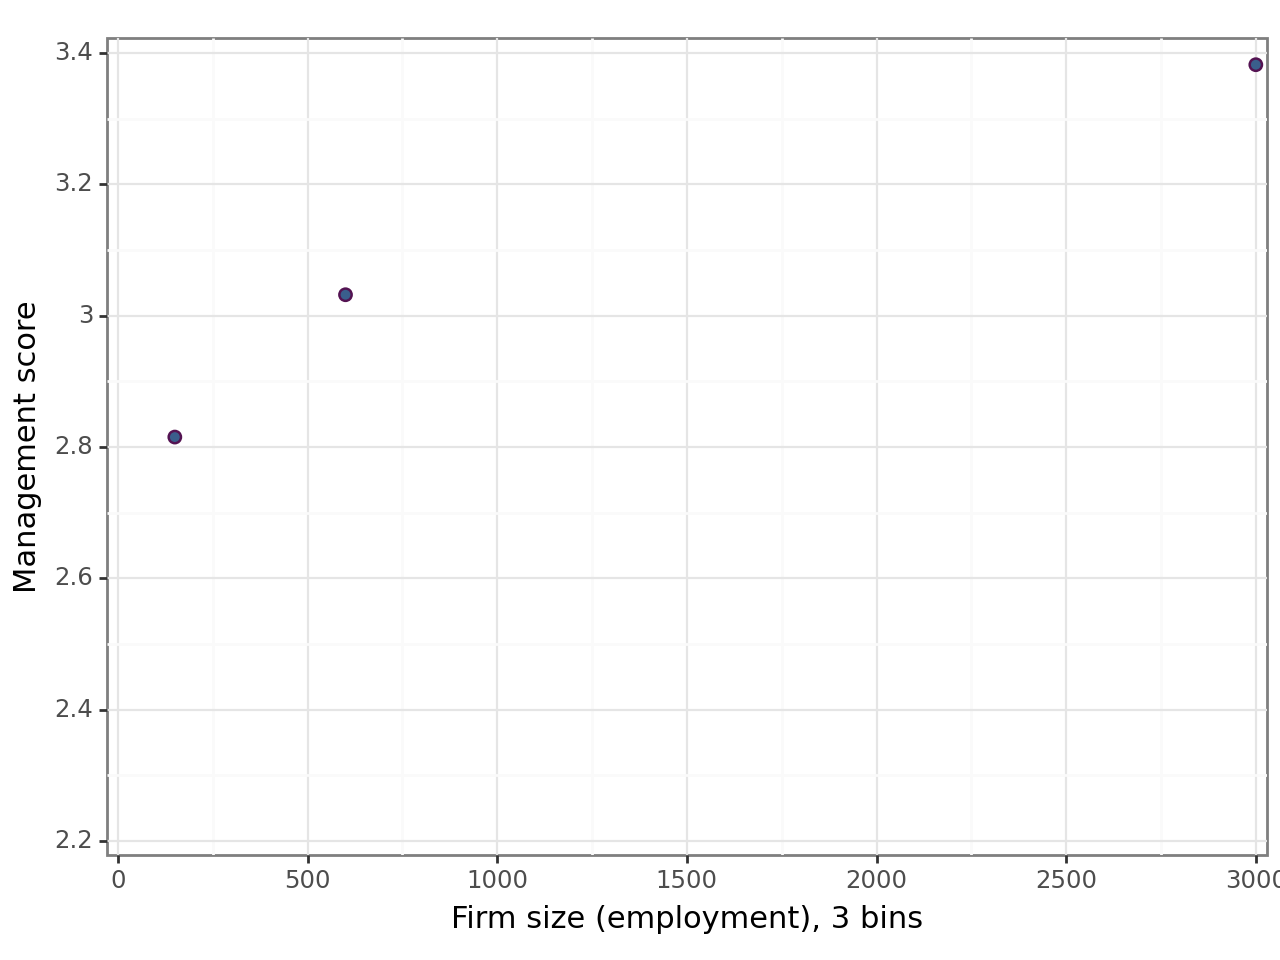

<Figure Size: (640 x 480)>

In [36]:
ggplot(df1, aes(x="emp3bins", y="management_emp3bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.2, 3.4), breaks=seq(2.2, 3.5, by=0.2)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3000), breaks=seq(0, 3001, by=500)
) + labs(
    x="Firm size (employment), 3 bins", y="Management score"
) + theme_bw()

<p>As we can observe, there is a clear <b>positive</b> association. Larger firms, on average, are better managed. We got a mean score of 2.41 for small firms, 2.75 for medium-sized firms, and 3.14 for large firms. As expected, these mean values are lower than in Mexican firms for all three bins (2.67, 2.94, and 3.18, respectively). Yet, the overall correlation is very similar.</p>

<p>Now, would this association hold when using a bin scatter of 10 bins? Let's find out.</p>
<h4>4.2.2 Ten-bin scatter</h4>

In [37]:
df["emp10bins"] = pd.qcut(df["emp_firm"],10)

<p>We just applied an interesting function, <code>qcut()</code>, that discretizes variables into equal-sized buckets. I had no idea that such a function existed, so helpful!</p>

In [38]:
# Summary
df_summary = df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)
df_summary

emp_firm                                               
                      min     max         mean  median          std size
emp10bins                                                               
(99.999, 120.0]     100.0   120.0   109.242424   110.0     8.299210   33
(120.0, 140.0]      123.0   140.0   133.250000   130.0     5.225472   28
(140.0, 165.0]      142.0   165.0   153.120000   150.0     6.918092   25
(165.0, 190.0]      170.0   190.0   178.821429   180.0     6.549264   28
(190.0, 240.0]      193.0   240.0   213.392857   205.0    15.900942   28
(240.0, 284.0]      245.0   284.0   257.000000   250.0    11.279662   27
(284.0, 400.0]      290.0   400.0   343.774194   350.0    36.618492   31
(400.0, 600.0]      407.0   600.0   515.518519   500.0    62.211408   27
(600.0, 1300.0]     630.0  1300.0   965.185185   900.0   228.462594   27
(1300.0, 4800.0]   1310.0  4800.0  2637.518519  2000.0  1205.331150   27

<p>We can now get the midpoint of each bin by replacing the interval with the mean of each interval.</p>

In [39]:
# Recode
df = df.replace({"emp10bins": df_summary["emp_firm"]["mean"].to_dict()})

In [40]:
df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(
    ["min", "max", "mean", "median", np.std, "size"]
)

emp_firm                                               
                        min     max         mean  median          std size
emp10bins                                                                 
109.24242424242425    100.0   120.0   109.242424   110.0     8.299210   33
133.25                123.0   140.0   133.250000   130.0     5.225472   28
153.12                142.0   165.0   153.120000   150.0     6.918092   25
178.82142857142858    170.0   190.0   178.821429   180.0     6.549264   28
213.39285714285714    193.0   240.0   213.392857   205.0    15.900942   28
257.0                 245.0   284.0   257.000000   250.0    11.279662   27
343.7741935483871     290.0   400.0   343.774194   350.0    36.618492   31
515.5185185185185     407.0   600.0   515.518519   500.0    62.211408   27
965.1851851851852     630.0  1300.0   965.185185   900.0   228.462594   27
2637.5185185185187   1310.0  4800.0  2637.518519  2000.0  1205.331150   27

In [41]:
# Return variables by mean
df1 = df.groupby("emp10bins").agg(management_emp10bins=("management", "mean")).reset_index()
df1

,emp10bins,management_emp10bins
0,109.242424,2.661616
1,133.250000,2.654762
2,153.120000,2.880000
3,178.821429,3.095238
4,213.392857,3.003968
5,257.000000,2.888889
6,343.774194,3.037424
7,515.518519,3.080247
8,965.185185,3.283951
9,2637.518519,3.409465


In [42]:
df1 = df1[["emp10bins", "management_emp10bins"]].astype("float64")

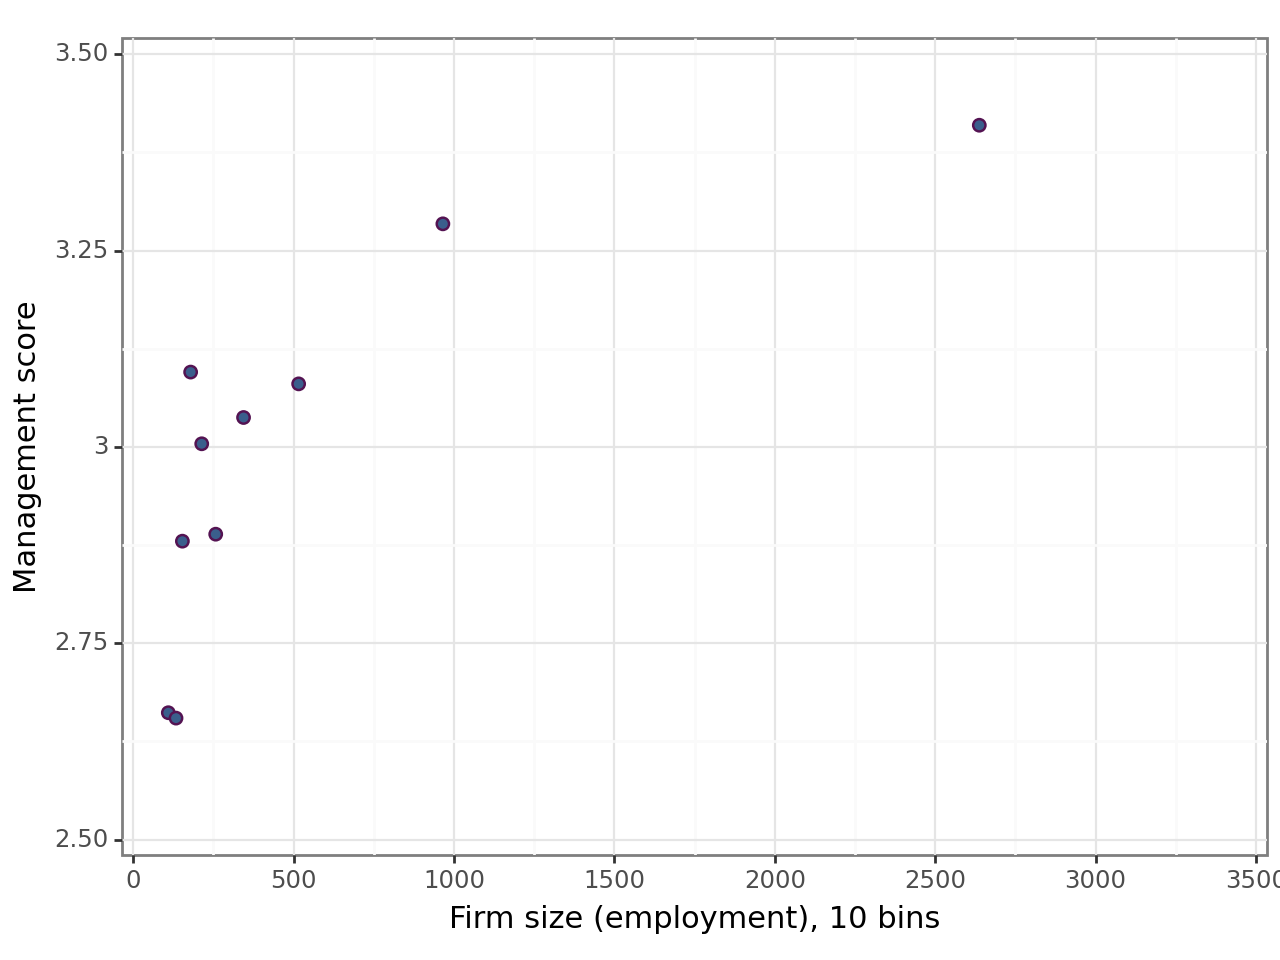

<Figure Size: (640 x 480)>

In [43]:
ggplot(df1, aes(x="emp10bins", y="management_emp10bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.5, 3.5), breaks=seq(2.5, 3.6, by=0.25)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3500), breaks=seq(0, 3501, by=500)
) + labs(
    x="Firm size (employment), 10 bins", y="Management score"
) + theme_bw()

The bin scatter, binned in 10 bins, returned a somewhat **linear relationship**, as the average management score tended to increase as the firm size increased. Large firms, however, did not registered an increase in the same magnitude, yet, overall, the positive correlation between firm size and management score is clearly visible. We can also notice the high degree of **skewness** in both bin scatters, which reflects the distribution of our dataset.
What about Brazilian firms vs Mexican firms? Well, Brazilian firms displayed a more positive correlation when compared to their Mexican counterparts. While the average value for each bin did not change significantly for Mexican firms with between around 300 and 1000 employees, Brazilian firms displayed a clearly positive correlation. And that is also related to the fact that smaller Mexican firms achieved higher scores than Brazilian ones. Perhaps in Brazil, firm size and management score are more positively correlated.

We can now plot a **scatterplot** of all observations to see if all large firms really displayed better management scores considering their conditional mean values.

<h3>4.3 Scatterplot</h3>

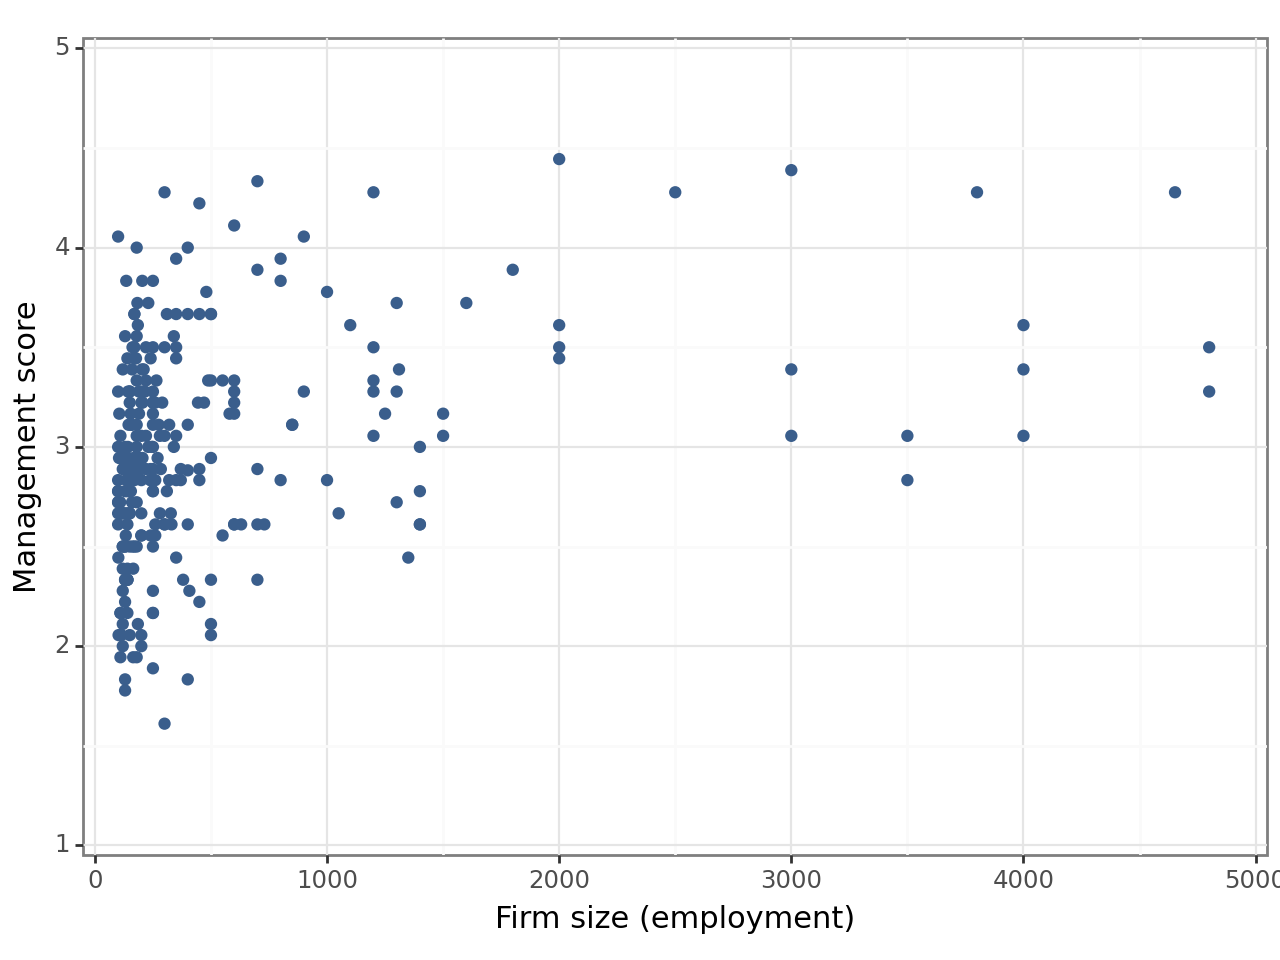

<Figure Size: (640 x 480)>

In [44]:
ggplot(df, aes(x="emp_firm", y="management")) + geom_point(
    size=1.5, color=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5000), breaks=seq(0, 5001, by=1000)
) + labs(
    x="Firm size (employment)", y="Management score"
) + theme_bw()

<p>Because the distribution of our data is highly skewed, we cannot see a clear pattern. We can apply the natural log of the employment on the x axis, which translates into a stretched difference between firms at lower levels of employment. Let's observe the results below:</p>

In [45]:
df["lnemp"] = np.log(df["emp_firm"])

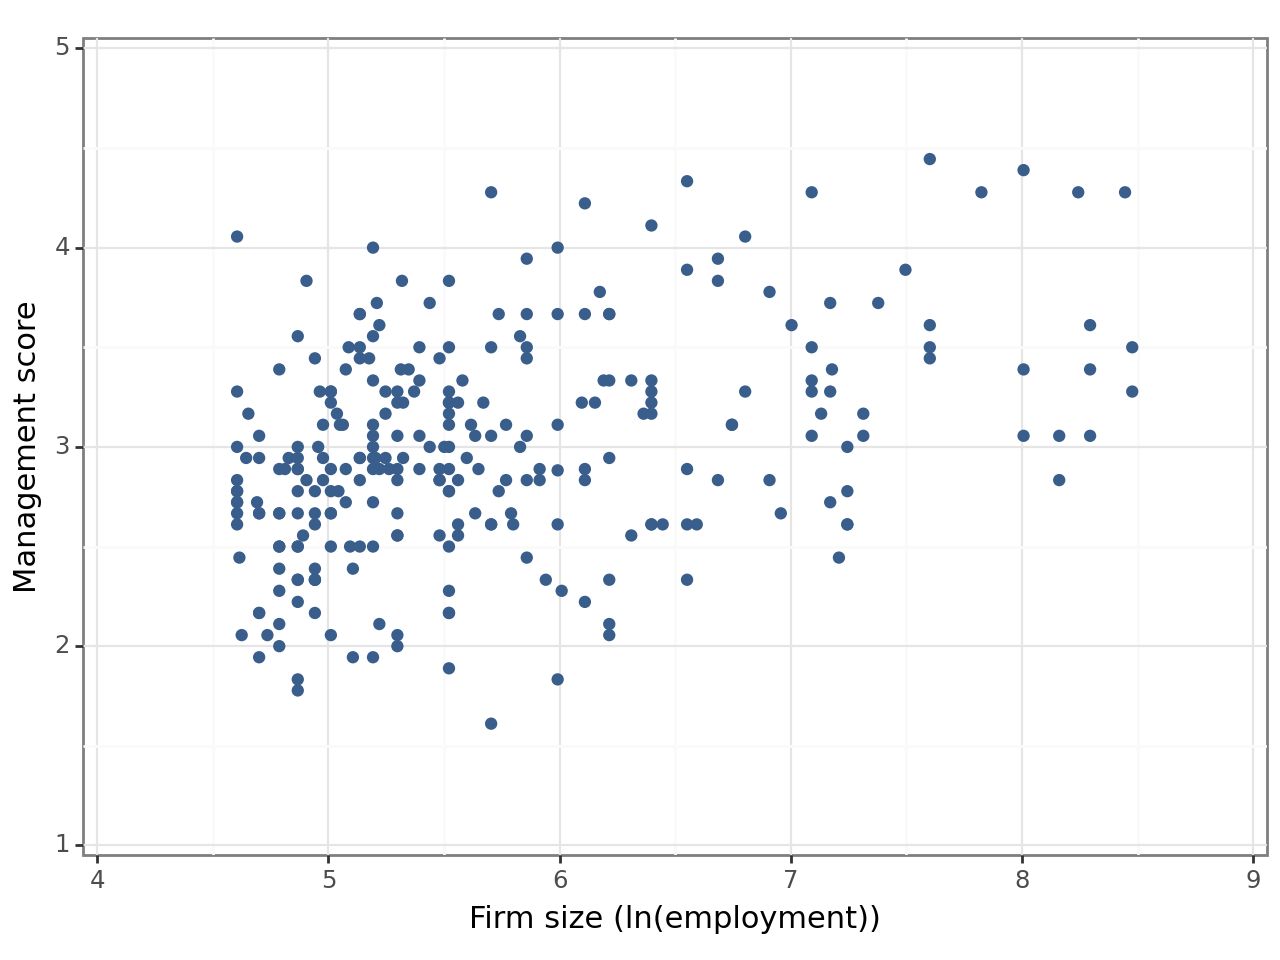

<Figure Size: (640 x 480)>

In [46]:
ggplot(df, aes(x="lnemp", y="management")) + geom_point(
    size=1.5, color=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(4, 9), breaks=seq(4, 10, by=1)
) + labs(
    x="Firm size (ln(employment))", y="Management score"
) + theme_bw()

<p>With our observations spread out, we can observe a positive correlation between management score and firm size. However, we also see a lot of variation of the management score at every level of employment - there is a lot of spread of the management score among firms with the same size.</p>
<p>Brazilian and Mexican firms displayed a similar degree of spread of the data. Across all firm sizes, we can see a lot of variation despite the visible positive correlation between the dependent and the explanatory variable.</p>
<p>To get more insight into whether - and to what extent - the spread or skewness of the managmeent score distribution differ at different levels of employments, we can produce <b>box plots</b> and <b>violin plots</b> of the management score for three employment bins.</p>
<h3>4.4 Box plots and violin plots to visualize the spread of the data</h3>

In [47]:
df = df.replace({"emp3bins":{
                    150: "Small",
                    600: "Medium",
                    3000: "Large",}
                    })

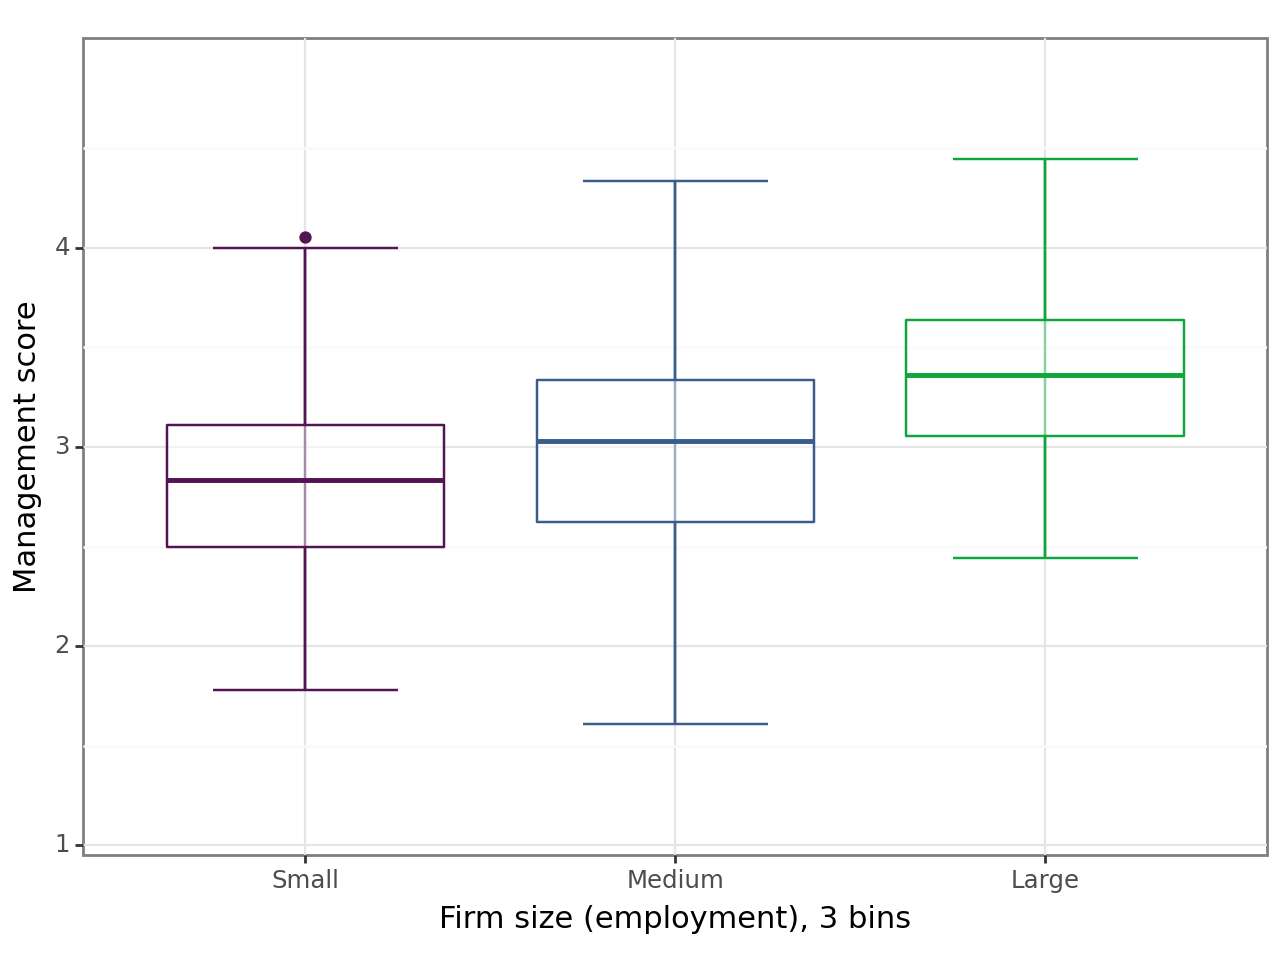

<Figure Size: (640 x 480)>

In [48]:
# Bot plots
ggplot(df, aes(x="pd.Categorical(df['emp3bins'], categories=sorted(set(df['emp3bins']), reverse=True))",
               y="management",
               ),
    ) + stat_boxplot(
        aes(group="emp3bins"),
        geom="errorbar",
        width=0.5,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    ) + geom_boxplot(
        aes(group="emp3bins"),
        color=(color[2], color[0], color[1]),
        size=0.5,
        alpha=0.5,
        na_rm=True,
    ) + labs(
        x="Firm size (employment), 3 bins",
        y="Management score"
    ) + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 1)
    ) + theme_bw()

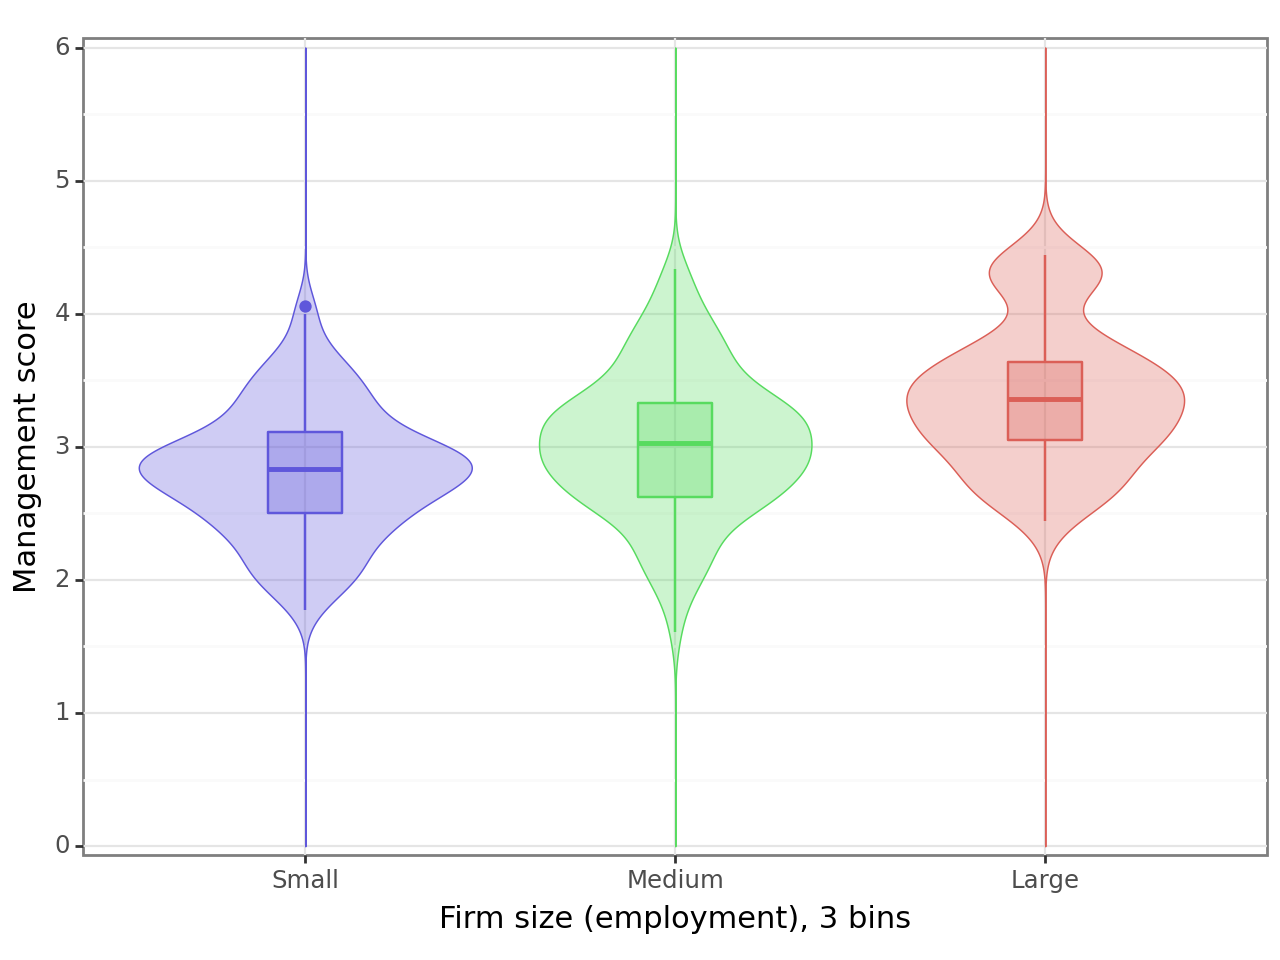

<Figure Size: (640 x 480)>

In [49]:
ggplot(df, 
       aes(x="pd.Categorical(df['emp3bins'], categories=sorted(set(df['emp3bins']), reverse=True))",
           y="management",
           color="emp3bins",
           fill="emp3bins",    
               ),
    ) + geom_violin(
        aes(group="emp3bins"),
        alpha=0.3,
        size=0.3,
        trim=False,
        show_legend=False,
        na_rm=True,
    ) + geom_boxplot(
        aes(group="emp3bins"),
        size=0.5,
        alpha=0.3,
        width=0.2,
        na_rm=True,
    ) + labs(
        x="Firm size (employment), 3 bins",
        y="Management score"
    ) + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 6), breaks=seq(0, 7, 1)
    ) + guides(
        fill=False, color=False
    ) + theme_bw()

We can notice a few things regarding those two plots.
- As the firm size increase, Brazilian firms displayed a **higher median management score**. 
- This positive pattern is noticeable in other statistics. The **min, max, lower, and upper quartiles** also increase as the firm size increase.
- There is a significant difference when considering the spread of the data vs Mexican firms. Small companies in Brazil display a **wider spread of management score**, while that was the oposite case in Mexican firms with a similar size. Overall, Mexican firms displayed higher median values as well.
- The violin plot helps us observe the concentration of the data around certain areas. Here, we can notice how Brazilian small firms display a wider spread of data. This pattern is somewhat noticeable among medium and large-sized firmes too, as the shape of the violin plots is larger around the median yet not too narrow on the end parts.

<h3>4.5 Correlation and latent variable</h3>
<p>A <b>latent variable</b> is an abstract variable, which is not a part of the dataset by itself, as it cannot be directly measured. Instead, we use <b>proxy variables</b>, which indeed replace them as a way to measure its original variables.</p>
<p>

In [50]:
# get the covariance between firm size and management score
covariance = round(df["emp_firm"].cov(df["management"]),2)

In [51]:
df_results = pd.DataFrame(
    data={"covariance": covariance,
     "firm_size_std": df["emp_firm"].std(),
     "management_score_std": df["management"].std(),
     "corr_coef": df["emp_firm"].corr(df["management"])},
     index=[0]
)
df_results

,covariance,firm_size_std,management_score_std,corr_coef
0,149.34,818.237523,0.546452,0.333999


<p>As we can see, the covariance between firm size and the management score is <b>206</b>. The standard deviation for both variables is <b>936.19</b> and <b>0.58</b>, respectively. The correlation coefficient is <b>0.30</b>. This outcome hints at a <b>positive</b> association, whereas firms with more employees tend to have higher management score. Such magnitude, however, is moderate, as other factors may impinge on management score in addition to the size of a company.</p>
<p>Brazilian firms displayed a <b>more positive correlation</b> between firm size and management score than Mexican firms. For the latter, the coefficient was 0.30 and the standard deviation for management score, 0.60.</p>
<p>We can analyze the correlation coefficient in seven broad categories of industrial classification (in addition to one "other" category with the industry with very few firms, combined).

In [52]:
# Correlation by industry
df["industry_broad"] = pd.np.NaN
df.loc[df["sic"] <= 21, "industry_broad"] = "foods_drink_tobacco"
df.loc[
    ((df["sic"] >= 22) & (df["sic"] <= 23)) | (df["sic"] == 31), "industry_broad" 
] = "textile_apparel_leather_etc"
df.loc[(df["sic"] >= 24) & (df["sic"] <= 27), "industry_broad"] = "wood_furniture_paper"
df.loc[(df["sic"] >= 28) & (df["sic"] <= 30), "industry_broad"] = "chemicals_etc"
df.loc[(df["sic"] >= 32) & (df["sic"] < 35), "industry_broad"] = "materials_metals"
df.loc[(df["sic"] >= 35) & (df["sic"] <= 37), "industry_broad"] = "electronics"
df.loc[(df["sic"] == 37) , "industry_broad"] = "auto"
df.loc[(df["sic"] >= 38) , "industry_broad"] = "other"

AttributeError: module 'pandas' has no attribute 'np'

In [ ]:
df["industry_broad"].value_counts()

chemicals_etc                  95
foods_drink_tobacco            76
electronics                    73
textile_apparel_leather_etc    71
wood_furniture_paper           70
materials_metals               65
auto                           44
other                          12
Name: industry_broad, dtype: int64

In [ ]:
# Check correlation
df.groupby("industry_broad")["management", "emp_firm"].corr().iloc[0::2, -1]

industry_broad                         
auto                         management    0.278674
chemicals_etc                management    0.302323
electronics                  management    0.547152
foods_drink_tobacco          management    0.332849
materials_metals             management    0.381071
other                        management    0.270929
textile_apparel_leather_etc  management    0.391246
wood_furniture_paper         management    0.527765
Name: emp_firm, dtype: float64

In [ ]:
df.filter(["management", "industry_broad"]).loc[
    lambda x: ~x["industry_broad"].isnull()
].groupby("industry_broad").agg(
    Min=("management", min),
    Max=("management", max),
    SD=("management", np.std),
    Median=("management", "median"),
    n=("management", "size")
)

,Min,Max,SD,Median,n
industry_broad,,,,,
auto,1.388889,4.388889,0.558338,3.055556,44
chemicals_etc,1.111111,3.944444,0.511611,2.833333,95
electronics,1.555556,4.277778,0.617068,2.944444,73
foods_drink_tobacco,1.166667,4.222222,0.640897,2.666667,76
materials_metals,1.055556,4.222222,0.557378,2.777778,65
other,1.555556,3.111111,0.440295,2.916667,12
textile_apparel_leather_etc,1.444444,3.555556,0.488979,2.500000,71
wood_furniture_paper,1.166667,4.500000,0.636101,2.527778,70


In [ ]:
# Check correlation
cor = (
    pd.DataFrame(
        df.groupby("industry_broad")["management", "emp_firm"].corr().iloc[0::2, -1]
    )
    .reset_index()
    .drop(["level_1"], axis=1)
)

In [ ]:
cor.columns = ["industry_broad", "COR"]
cor = cor.set_index("industry_broad")

In [ ]:
table = (
    df.filter(["emp_firm", "industry_broad", "management"])
    .groupby("industry_broad")
    .agg(Mean=("management", "mean"), Obs=("management", "size"))
)

table["cor"] = cor["COR"]

In [ ]:
table.index = [
    "Auto",
    "Chemicals",
    "Machinery, equipment, electroncis",
    "Food, drinks, tobacco",
    "Materials, metals",
    "Textile, apparel, leather",
    "Wood, furniture, paper",
    "Other",
]
table.round(2)

,Mean,Obs,cor
Auto,2.95,44,0.28
Chemicals,2.88,95,0.30
"Machinery, equipment, electroncis",2.90,73,0.55
"Food, frinks, tobacco",2.63,76,0.33
"Materials, metals",2.71,65,0.38
"Textile, apparel, leather",2.73,12,0.27
"Wood, furniture, paper",2.52,71,0.39
Other,2.59,70,0.53


In [ ]:
last_row = (
    table.groupby(lambda _: True)
    .agg(Mean=("Mean", "mean"), Obs=("Obs", "sum"), cor=("cor", "mean"))
    .reset_index(drop=True)
)

last_row.index = ["All"]

In [ ]:
table = table.append(last_row)

In [ ]:
table = table.loc[:, ["cor", "Mean", "Obs"]].reset_index()
table.columns = [
    "Industry",
    "Management - employment correlation",
    "Management score",
    "Observations",
]

In [ ]:
table.round(2)

,Industry,Management - employment correlation,Management score,Observations
0,Auto,0.28,2.95,44
1,Chemicals,0.30,2.88,95
2,"Machinery, equipment, electroncis",0.55,2.90,73
3,"Food, frinks, tobacco",0.33,2.63,76
4,"Materials, metals",0.38,2.71,65
5,"Textile, apparel, leather",0.27,2.73,12
6,"Wood, furniture, paper",0.39,2.52,71
7,Other,0.53,2.59,70
8,All,0.38,2.74,506


As we can observe, the correlation between firm size and management scores varies across industries. `Other` and `Machinery, equipment, electronics` categories displayed significantly higher correlation coefficients. Other industries such as materials, metals and wood, furniture, and paper also performed slightly above the average too. It is also remarkable how the average management score did not differ as much across industriesm with a min average of 2.52 and a max of 2.95. We can conclude that other factors such as firm size may affect how well companies in Brazil perform.

Now, let's compare these results with Mexican firms. First, Brazilian firms overall display a stronger correlation between firm size and management score. While some Mexican industries such as Auto and Textiles displayed significant correlation coefficients (0.50 and 0.63, respectively), others had nearly no correlation, such as Food, Drinks, and Tobacco, and Chemicals (0.05 in both cases). Mean management scores also varied more, ranging from 2.72 and 3.29. When comparing firms from both countries, thus, we can affirm that firm size holds a stronger correlation with management score in Brazil and may affect the quality of management in a higher degree than in Mexico, whose firms get higher mean scores despite firm size, in some cases.

<h2>5. Conclusion</h2>
<p>What did we learn about the association between firm size and management quality? How do these results compare to our findings for Mexico?</p>
<ul>
<li>Among Brazilian manufacturing firms, larger firms tend to be better managed. </li>
<li>There was a <b>difference</b> between small firms in Brazil and in Mexico. In this case, firms from the former showed a higher variability of management score, which tended to increase as the company increased in size. For the latter, management score was overall higher and with a weaker correlation with the number of employees. This difference became noticeable when plotting the scatter bin with 10 bins.</li>
<ul>
<li>Large firms have an average score of <b>3.15</b>, compared to <b>2.75</b> for medium-sized firms, and <b>2.41</b> for small ones. When compared to Mexican scores (3.19, 2.94, and 2.68), we can notice that Brazilian firms performed relatively worse.</li>
</ul>
<li>The correlation, even though positive, is <b>not very strong</b>. Maybe other issues also affect the quality of management besides firm size. The correlation coefficient in Brazil (0.38), however, as stronger than in Mexico (0.31). We could notice a stronger correlation among smaller firms, as in Mexico, such pattern was not as evident.</li>
<li>When disaggregating the results into smaller industry groups, we found that the strength of the management-size correlation differs in some industries from the rest, although we have not observed any pattern that would tell us why.</li>
</ul>
<p>With these final statements, we conclude our data exercise. We could definetely observe a positive yet mild correlation between firm size and management score. Still, the high degree of variability showed that just the number of employees is not enough to explain good (or bad) management scores!</p>
<p>Thank you for reading!</p>
<hr>